In [8]:
import numpy as np
import json
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import tomlkit

# step = 5700
# log_dir = Path("records/conll03-mpu/tagger/vis/2022-11-23_11-16-21.712440")     # Proto4-ot
step = 3350
log_dir = Path("records/conll03-mpu/tagger/vis/2022-11-22_14-34-09.073507")     # cos nonparam proto4
# step = 1450
step = 3050
log_dir = Path("records/conll03-mpu/tagger/vis/2022-11-30_19-20-16.308219")     # l2 nonparam proto4
step = 3100
log_dir = Path("records/conll03-dict/tagger/vis/2022-12-08_00-10-32.996989")     # cos nonparam proto4
# step = 1550
# log_dir = Path("records/conll03-dict/tagger/vis/2022-12-07_20-42-12.912966")     # cos nonparam proto1
# step = 1600
# log_dir = Path("records/conll03-dict/tagger/vis/2022-12-07_23-44-42.617211")     # cos nonparam proto4 neg0.2
# step = 2900
# log_dir = Path("records/conll03-dict/tagger/vis/2022-12-07_23-44-43.668391")     # cos nonparam proto4 neg1.0
ids_path = log_dir / "detail_log" / "sample{}.json".format(step)
hidden_path = ids_path.with_stem(ids_path.stem + "_tsne").with_suffix(".npy")
samples_path = Path("data/datasets/conll03-dict/train.jsonl")
meta_path = Path("data/datasets/conll03-dict/meta.json")

with (log_dir / "cfg.toml").open('r', encoding="utf8") as rf:
    cfg = tomlkit.load(rf)

with meta_path.open('r', encoding="utf8") as rf:
    meta = json.load(rf)
id2type = ["None"]
# specified entity types
for i, (key, v) in enumerate(meta['entities'].items()):
    if key == "None":
        # 一般而言不会重载None
        pass
    else:
        id2type.append(key)
type2id = {v: i for i, v in enumerate(id2type)}

id2sample = {}
with samples_path.open('r', encoding="utf8") as rf:
    for line in rf:
        sample = json.loads(line)
        id2sample[sample["id"]] = sample

hiddens = np.load(hidden_path)
print(hiddens.shape)
samples = []
sent_lens = []
with ids_path.open('r', encoding="utf8") as rf:
    ids = json.load(rf)
    for sample_id in ids:
        samples.append(id2sample[sample_id])
        sent_lens.append(len(samples[-1]["tokens"]))
 
assert sum(sent_lens) == len(hiddens)
pivots = np.cumsum(np.asarray(sent_lens))
hiddens = np.split(hiddens, pivots)
data = {ty: [] for ty in id2type}
for sample, hidden in zip(samples, hiddens):
    assert len(sample["tokens"]) == len(hidden), "{} != {}".format(hidden.shape, sample["tokens"])
    ds_labels = ["None"] * len(hidden)
    hu_labels = ["None"] * len(hidden)
    for e in sample["entities"]:
        for i in range(e["start"], e["end"]):
            ds_labels[i] = e["type"]
    for e in sample["human_entities"]:
        for i in range(e["start"], e["end"]):
            hu_labels[i] = e["type"]
    for tok_hidden, ds_label, hu_label in zip(hidden, ds_labels, hu_labels):
        if hu_label == "None":
            # O数据，不考虑远程监督是不是标上了，我们考虑真实数据
            # data.append((tok_hidden[0], tok_hidden[1], "O"))
            pass
        elif hu_label != ds_label:
            # 实体，但是missing label
            data[hu_label].append((tok_hidden[0], tok_hidden[1], "un-{}".format(hu_label), "hidden"))
        else:
            # 实体，正确标注
            data[hu_label].append((tok_hidden[0], tok_hidden[1], hu_label, "hidden"))

proto_path = log_dir / "detail_log" / "proto{}_tsne.npy".format(step)
if proto_path.exists():
    num_proto_per_type = cfg["model"]["num_proto_per_type"]
    protos = np.load(proto_path)
    print("ProtoSize = {}".format(protos.shape))
    for ty_index in range(len(type2id)):
        ty_label = id2type[ty_index]
        for ty_proto in protos[ty_index * num_proto_per_type: (ty_index + 1) * num_proto_per_type]:
            data[ty_label].append((ty_proto[0], ty_proto[1], ty_label, "proto"))

(203621, 2)
ProtoSize = (20, 2)


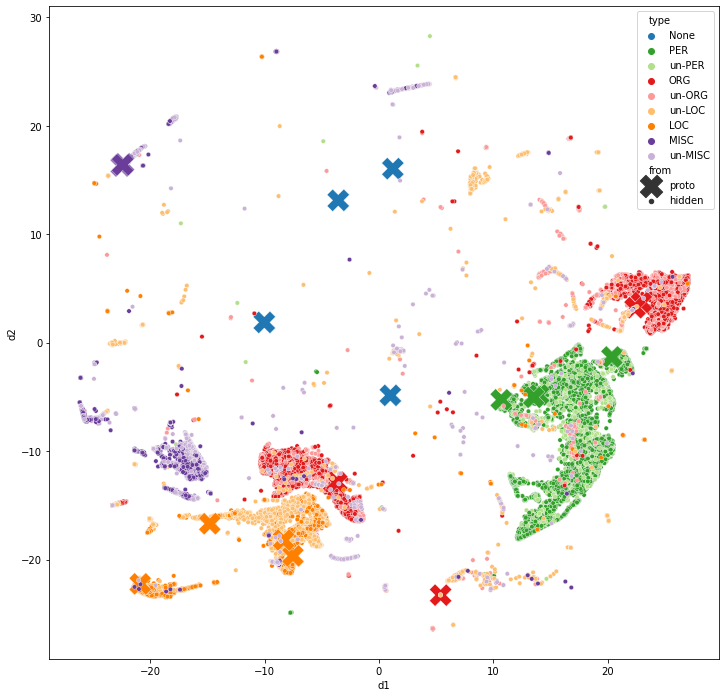

In [9]:
plt.rcParams['figure.figsize'] = [12, 12]
all_data = []
palette = {}
palet = sns.color_palette("Paired", len(data) * 2)
for i, (ty, ty_data) in enumerate(data.items()):
    all_data.extend(ty_data)
    palette[ty] = palet[2 * i + 1]
    palette["un-" + ty] = palet[2 * i]
df_tsne = pd.DataFrame(all_data, columns=['d1', 'd2', 'type', 'from'])
markers = {"hidden": "o", "proto": "X"}
sns.scatterplot(
    data=df_tsne, x='d1', y='d2', 
    hue='type', palette=palette, 
    style="from", markers=markers,
    size="from", sizes={"hidden": 20, "proto": 500}
) 
plt.show()

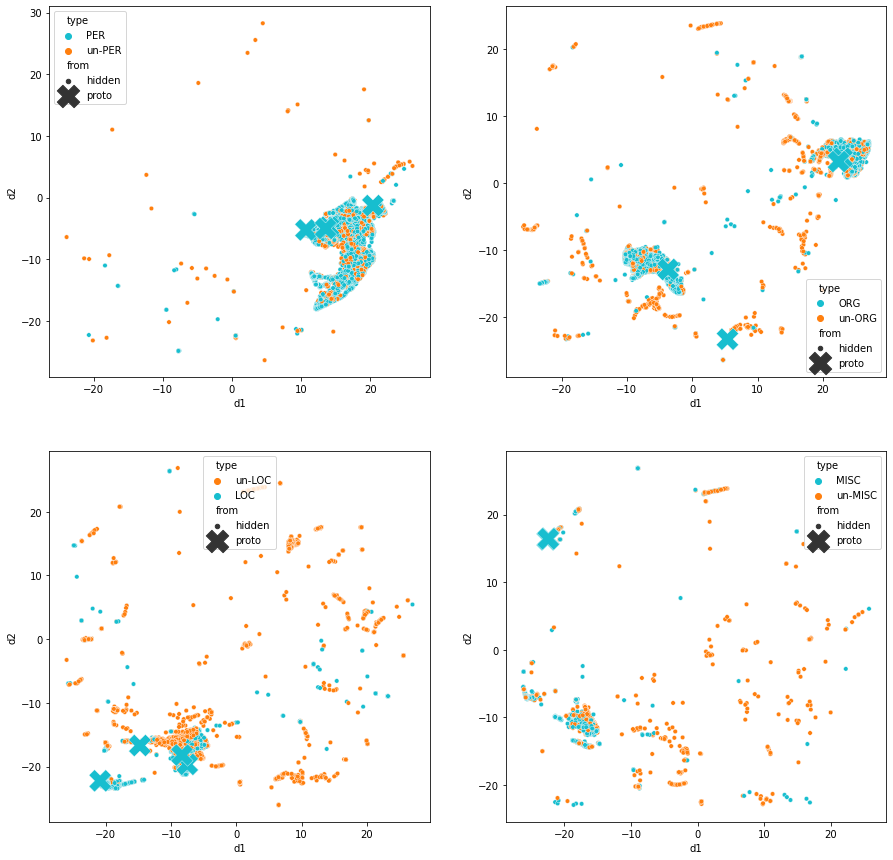

In [10]:
data.pop("None")
assert len(data) <= 4
plt.rcParams['figure.figsize'] = [15, 15]
fig, axes = plt.subplots(2, 2)
for i, (ty, ty_data) in enumerate(data.items()):
    df_tsne = pd.DataFrame(ty_data, columns=['d1', 'd2', 'type', 'from'])
    palette = {ty:"tab:cyan", "un-{}".format(ty):"tab:orange"}
    markers = {"hidden": "o", "proto": "X"}
    sns.scatterplot(data=df_tsne, x='d1', y='d2', 
                    hue='type', palette=palette, 
                    style="from", markers=markers,
                    size="from", sizes={"hidden": 20, "proto": 500}, 
                    ax=axes[i // 2][ i % 2]) 
plt.show()